<a href="https://colab.research.google.com/github/sunil448832/Deep-Learning/blob/main/RBF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# **MNIST Data Classification using Radial basis function**

In [9]:
def preprocess(img):
  img = ImageOps.grayscale(img)
  img = torch.Tensor(np.array(img)).reshape(-1)
  return img.float()/255.0

train = torchvision.datasets.MNIST('/content/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([preprocess]))

test = torchvision.datasets.MNIST('/content/files/', train=False,download=True,
                            transform=torchvision.transforms.Compose([preprocess]))
size=len(train.targets)

In [10]:
train_dataset=torch.utils.data.Subset(train,range(int(.7*size)))
val_dataset=torch.utils.data.Subset(train,range(int(.7*size),size))



# **Radial basis function**

In [4]:
class RBF(nn.Module):
  def __init__(self,input_dim,centers):
    super(RBF,self).__init__()
    self.input_dim=input_dim
    self.centers=centers
    self.mean= torch.nn.Parameter(torch.randn(centers,input_dim)) # mean shape=( #centers , input_dim)
    self.std_inv= torch.nn.Parameter(torch.randn(centers))    # standerd_deviation inverse shape =(#centers, 1)
    self.classifier=nn.Linear(centers,10)   
  
  def gaussian_activation(self,input):

    #repeating the inputs till numbers of centers so that (input-mean) is feasible;
    input=input.unsqueeze(dim=1)
    input=input.repeat(1,self.centers,1).view(input.size(0),-1,input.size(-1))
    
    #reapeating the mean till batch size of input to make (input-mean) feasible
    mean=self.mean.unsqueeze(dim=0)
    mean=mean.repeat(input.size(0),1,1).view(-1,*self.mean.size())

    #repeating the std_inv till batch size of input to make (|input-mean|*std_inv) feasible
    std_inv=self.std_inv.unsqueeze(dim=0)
    std_inv=std_inv.repeat(input.size(0),1).view(-1,self.std_inv.size(-1))

    # Multinomial Gaussian Distributuon with given mean and std_inv   
    # Gaussian= e-(|input-mean|*std_inv)**2
    distance = (input - mean).pow(2).sum(-1).pow(0.5) * std_inv # (|input-mean|*std_inv)
    gaussian = torch.exp(-1*distance.pow(2))       # e-(distance)**2)
    return gaussian

  def forward(self,x):
    x=self.gaussian_activation(x)  #applying gaussian_activation
    return self.classifier(x) # classification

# **Model training**

In [5]:
!pip install -qqq wandb
!pip install -qqqU fastai
import wandb
from fastai.callback.wandb import *
from fastai.vision.all import *
from fastai.data.core import DataLoaders
wandb.login()

     |████████████████████████████████| 1.8MB 38.9MB/s 
     |████████████████████████████████| 163kB 55.9MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 133kB 49.1MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 194kB 21.4MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project='RBF')


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=1.3182567499825382e-06)

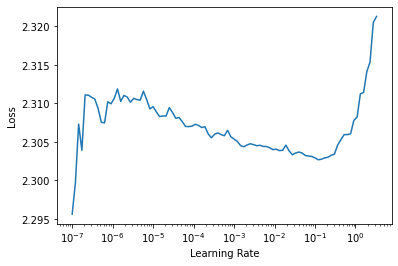

In [22]:
dls = DataLoaders.from_dsets(train_dataset, val_dataset).to(device)

model=RBF(28*28,100).to(device)
learn = Learner(dls,model,
                CrossEntropyLossFlat(),
                metrics=accuracy,
                cbs=WandbCallback(log_model=True))


learn.lr_find()

In [24]:
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.295485,2.294437,0.162000,00:13
1,2.156392,2.111764,0.273778,00:13
2,1.446366,1.392595,0.650722,00:13
3,1.051916,1.023755,0.761389,00:13
4,0.862681,0.836952,0.800000,00:13
5,0.760011,0.716580,0.840556,00:13
6,0.712681,0.661504,0.849389,00:13
7,0.670210,0.643371,0.844389,00:13
8,0.611483,0.587407,0.863778,00:13
9,0.593629,0.577237,0.863056,00:13
